# Workshop Time Series

In this workshop you will practice performing time series analysis.

Lesson goal: The student applies time series forecasting techniques to make predictions using a time series data set. This lesson goal relates to final qualification "data analytics".


We will be using a dataset containing energy consumption data for a heat pump. It contains the following columns:

- timestamp: timestamp
- E_apparaten: energy use of other devices in kWh
- E_warmtepomp: energy use of heatpump in kWh
- E_verbruik: total energy use in kWh
- Overschot: energy returned to grid
- hp_AAN: heatpump on or off
- diff_temp_woonk: temperature living room
- diff_temp_slaapk: temperature bedroom
- Tussendeur: inside door open / closed
- Buitendeur: outside door open / closed
- Raam: window open / closed
- Dag: weekday
- day_of_week: weekday (same as "Dag")
- month: month
- year: year

In this workshop we will focus on the E_warmtepomp column

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import statsmodels.tsa.api as tsa
from scipy.signal import savgol_filter, butter, filtfilt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [ ]:
# Read in the data
dfhp = pd.read_csv("data/heatpump_clean_filtered.csv")
dfhp['timestamp_dt'] = pd.to_datetime(dfhp['timestamp']) # Create a copy of the timestamp that is converted to a proper date time stamp object so Python can analyze it better.
dfhp

,timestamp,E_apparaten,E_warmtepomp,E_verbruik,overschot,hp_AAN,diff_temp_woonk,diff_temp_slaapk,Tussendeur,Buitendeur,Raam,Dag,day_of_week,month,year,timestamp_dt
0,2019-11-30 21:00:00,0.000000,0.000000,0.000000,0.000000,0.0,19.300000,17.800000,1.0,0.0,0.0,5,5,11,2019,2019-11-30 21:00:00
1,2019-11-30 21:30:00,0.012299,0.455955,0.468254,0.000000,1.0,19.594167,18.094167,1.0,0.0,0.0,5,5,11,2019,2019-11-30 21:30:00
2,2019-11-30 22:00:00,0.012543,0.464996,0.477539,0.000000,1.0,20.286389,18.884444,1.0,0.0,0.0,5,5,11,2019,2019-11-30 22:00:00
3,2019-11-30 22:30:00,0.023764,0.538520,0.562284,0.000000,1.0,20.790278,19.390278,1.0,0.0,0.0,5,5,11,2019,2019-11-30 22:30:00
4,2019-11-30 23:00:00,0.085571,0.608624,0.694196,0.000000,1.0,19.427222,18.223333,1.0,0.0,0.0,5,5,11,2019,2019-11-30 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2020-07-01 07:00:00,0.102798,0.002612,0.105410,0.000000,1.0,6.000000,6.600000,0.0,0.0,0.0,2,2,7,2020,2020-07-01 07:00:00
10245,2020-07-01 07:30:00,0.092111,0.010005,0.102116,0.000000,1.0,5.947889,6.521833,0.0,0.0,0.0,2,2,7,2020,2020-07-01 07:30:00
10246,2020-07-01 08:00:00,0.093163,0.007402,0.100565,0.001018,1.0,5.800000,6.300000,0.0,0.0,0.0,2,2,7,2020,2020-07-01 08:00:00
10247,2020-07-01 08:30:00,0.088124,0.002610,0.090734,0.034967,1.0,5.646187,6.146187,0.0,0.0,0.0,2,2,7,2020,2020-07-01 08:30:00


## Initial analysis

As there are 100,000 rows for our initial experiments for our first analyses we will summarize them or zoom on sub selections to avoid having to spend too much time waiting for calculations to complete. Later on you will work on the full data set.

For starters, lets sum the E_warmptepomp data for each day. Then plot the contents to see what we're dealing with.

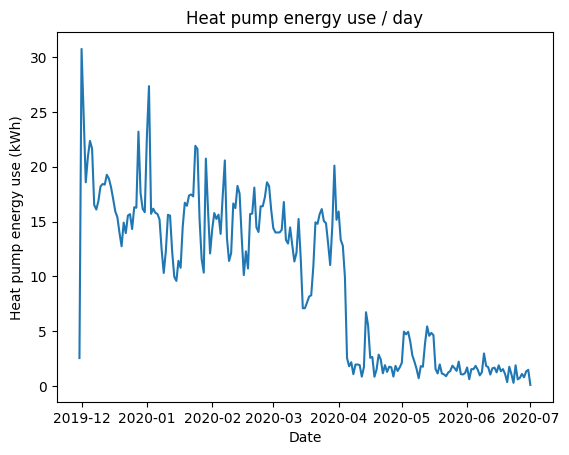

In [24]:
# To be able to sum by day we need to create a column that contains the day only.
# Note we use the to_datetime function to convert the date string to something
# that Python recognizes as a date object.
dfhp['datum'] = pd.to_datetime(dfhp['timestamp'].replace(' .*$', '', regex=True))
# Now sum the E_warmtepomp values for each day. Reset the index to obtain a dataframe instead of a groupby object.
df_sum = dfhp[['datum', 'E_warmtepomp']].groupby(by='datum').sum().reset_index()

plt.plot(df_sum['datum'], df_sum['E_warmtepomp'])
plt.title('Heat pump energy use / day')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.show()



Clearly there are some interesting things going on with the data. For our first experiments, these are inconvenient, however, so let's first zoom in on a sub selection of data, say from 2020-01-01 to 2020-04-01

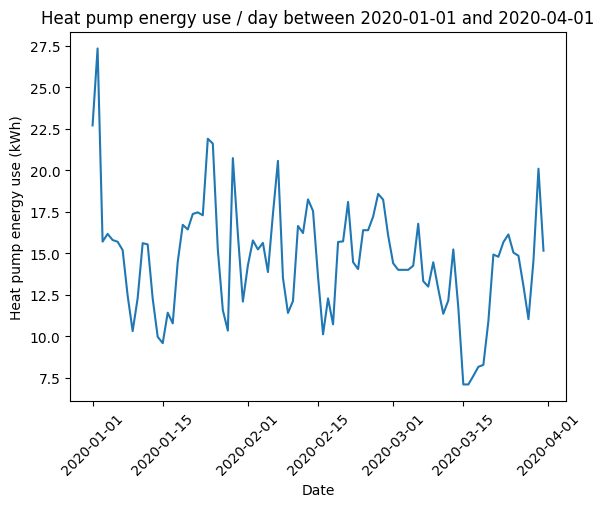

In [ ]:
df_sum_sel = df_sum[(df_sum['datum'] >= '2020-01-01') & (df_sum['datum'] < '2020-04-01')].reset_index(drop=True) # reset index is needed for ARIMA, later on.
plt.plot(df_sum_sel['datum'], df_sum_sel['E_warmtepomp'])
plt.title('Heat pump energy use / day between 2020-01-01 and 2020-04-01')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()


There does not seem to be an obvious pattern here. Let's create an autocorrelation function plot to see if this intuition is correct.

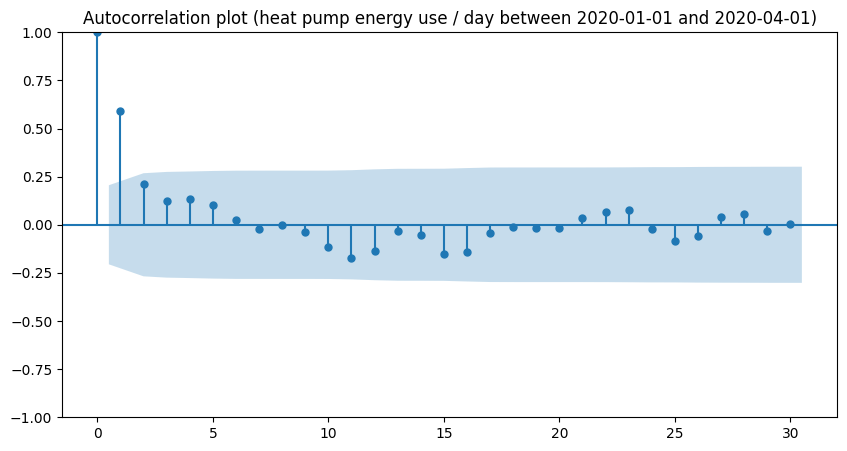

In [36]:
acf_plot = tsaplots.plot_acf(df_sum_sel["E_warmtepomp"], lags=30, title='Autocorrelation plot (heat pump energy use / day between 2020-01-01 and 2020-04-01)')

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
plt.show()

Autocorrelation is extremely weak, confirming our intuition that there is no obvious repeating pattern in the data.

However, there may be a seasonal effect in the data, albeit a weak one. Can you spot it?

Let's see if decomposition makes the effect more obvious.

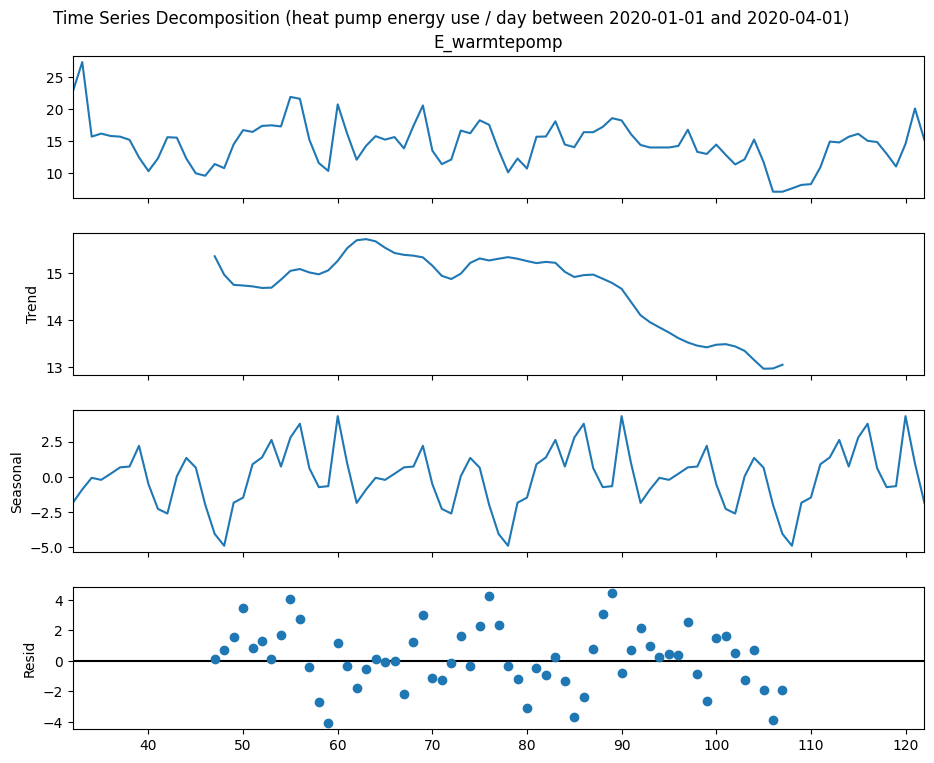

In [96]:

# Decompose the time series
result = seasonal_decompose(df_sum_sel["E_warmtepomp"], model="additive", period=30)

# Plot the decomposed components
decomposed = result.plot()

decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition (heat pump energy use / day between 2020-01-01 and 2020-04-01)")

plt.show()

There seems to be a clear, albeit small, trend in the data. Perhaps filtering would make this effect more obvious?

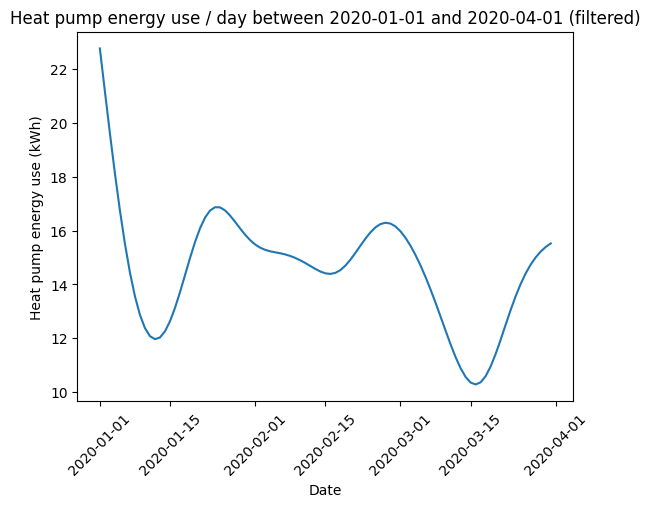

In [56]:
cutoff_frequency = 0.1  # Cutoff frequency as a fraction of the sampling rate
filter_order = 3  # Filter order
b, a = butter(filter_order, cutoff_frequency, btype="low", analog=False)
butterworth_filtered = filtfilt(b, a, df_sum_sel['E_warmtepomp'])

plt.plot(df_sum_sel['datum'], butterworth_filtered)
plt.title('Heat pump energy use / day between 2020-01-01 and 2020-04-01 (filtered)')
plt.ylabel('Heat pump energy use (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

Play around with the cutoff_frequency parameter to see if you can make the effect more pronounced.

## Try it yourself: analyze the full data set

Now try it yourself. Using the complete data set, analyse it for seasonality and trends. Make sure to use the dfhp['timestamp_ts'] column for the timestamp.

Play around with the values for the lags parameter and the period parameter

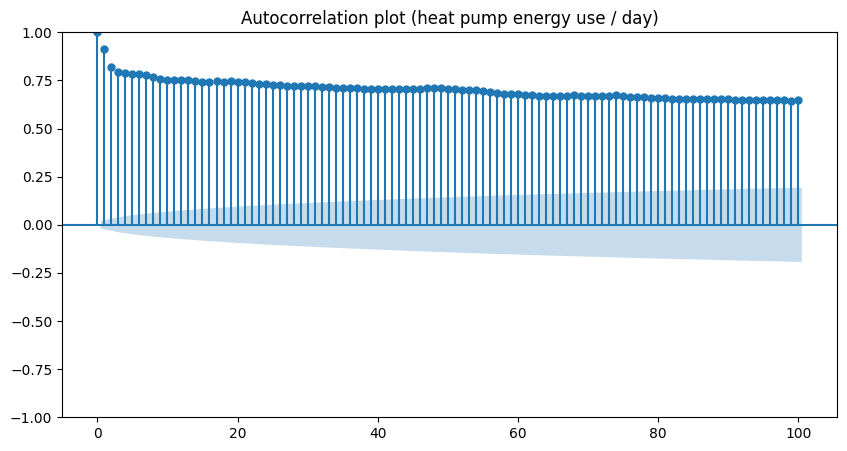

In [ ]:
# Your code for the ACF plot goes here. Try changing the lags parameter.



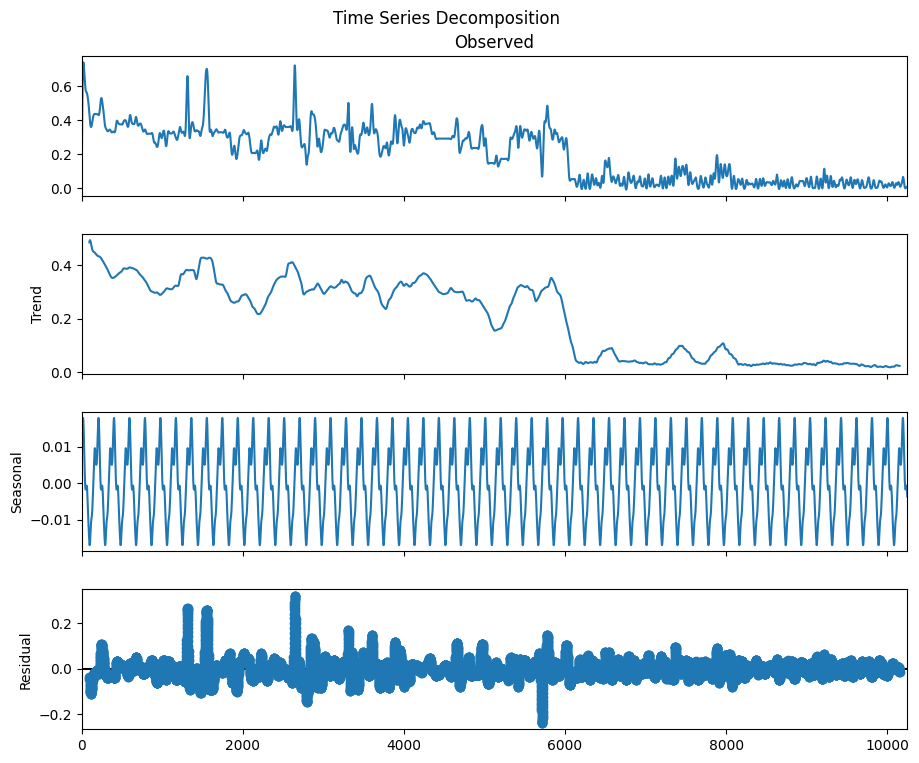

In [ ]:
# Your code for the decomposition goes here. Be sure to try changing the period parameter.
# If you have time, try filtering the data before decomposing it.


plt.show()

## Differencing

Our data has a (weak) trend. We can get rid of this trend by differencing. Doing so manually would be possible (refer to the lecture demos for an example) but Pandas has a differencing function built in so let's use that.

For the example we will again use the summarized data set.

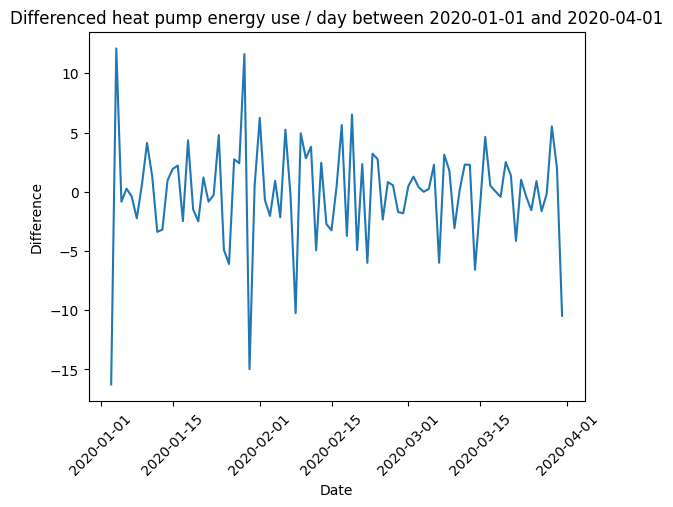

In [ ]:
# Without a value for the periods parameter it defaults to 1
sum_diff = df_sum_sel['E_warmtepomp'].diff(periods=1)
plt.plot(df_sum_sel['datum'], sum_diff)
plt.title('Differenced heat pump energy use / day between 2020-01-01 and 2020-04-01')
plt.ylabel('Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

Whereas before we had a slight downward trend after differencing that trend is gone.

To verify that the autocorrelation is now (mostly) gone, we can make an autocorrelation function plot for the differenced time series.



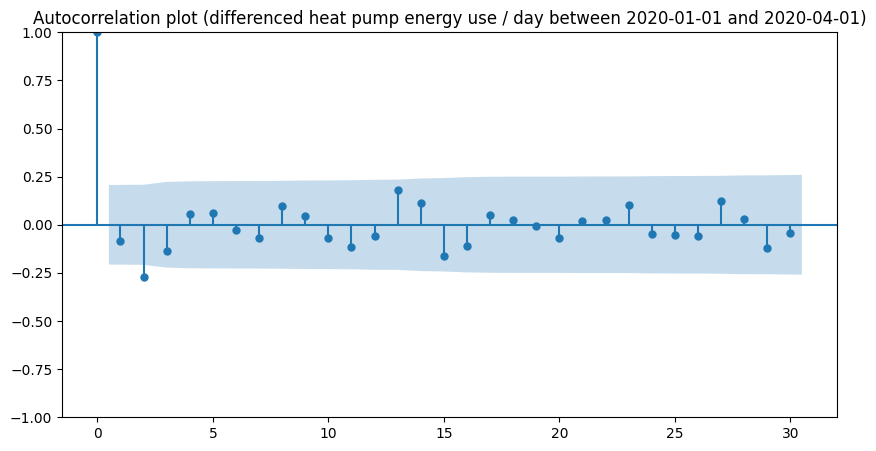

In [ ]:
# We need to dropna as the first value is now empty (nothing to diff with!)
acf_plot = tsaplots.plot_acf(df_sum_sel["E_warmtepomp"].diff().dropna(), lags=30, title='Autocorrelation plot (differenced heat pump energy use / day between 2020-01-01 and 2020-04-01)')

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
plt.show()

Correlations, especially the second one, are now much weaker. The trend may be too, but this is difficult to see as it was quite weak to begin with.

Let's try to decompose the differenced data.

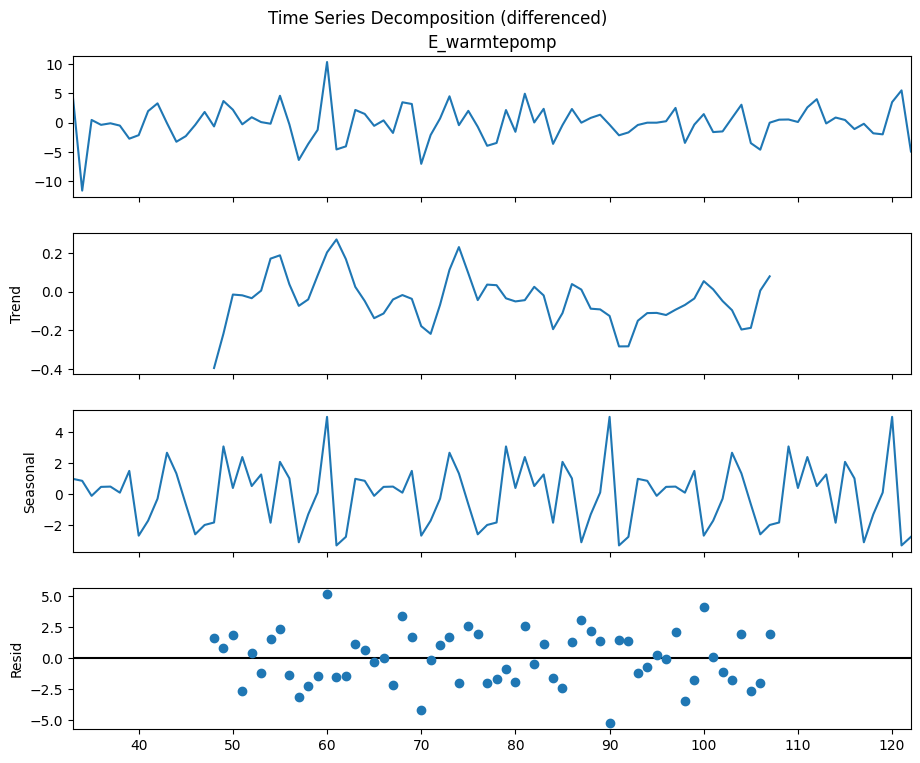

In [ ]:
# Decompose the time series
result = seasonal_decompose(df_sum_sel["E_warmtepomp"].diff().dropna(), model="additive", period=30)

# Plot the decomposed components
decomposed = result.plot()

decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition (differenced)")

plt.show()

The trend is clearly gone.

## Try it yourself: differencing

Try differencing the entire data set. Does this remove the trend? And does this remove the seasonality, too?

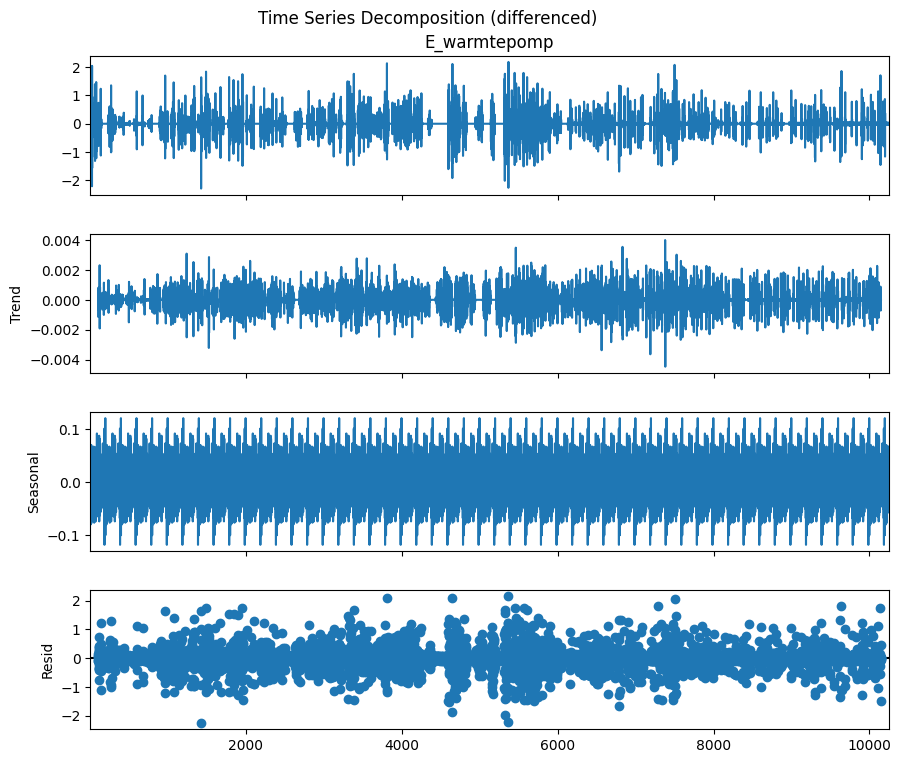

In [ ]:
# Your code goes here.



## Forecasting

Now that we have analyzed our time series we TODO

We will use the ARIMA model from the statsmodels.tsa.api package. Perhaps confusingly this is also the model to use for ARMA models - by setting the differencing order to 0 (which of course makes sense).



In [137]:
# Parameters for the ARIMA model
num_previous_terms = 1 # Commonly called p
differencing_order = 0 # Commonly called d. Should be 0 for ARMA
num_terms_moving_average = 1 # Commonly called q

model = tsa.ARIMA(df_sum_sel['E_warmtepomp'], order=(num_previous_terms, differencing_order, num_terms_moving_average))

fitted_model = model.fit()

fitted_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           E_warmtepomp   No. Observations:                   91
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -219.201
Date:                Wed, 03 Sep 2025   AIC                            446.403
Time:                        15:10:57   BIC                            456.446
Sample:                             0   HQIC                           450.455
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6560      0.673     21.763      0.000      13.336      15.976
ar.L1          0.3899      0.133      2.925      0.003       0.129       0.651
ma.L1          0.3563      0.166      2.153      0.031       0.032       0.681
sigma2         7.1963      1.003      7.175      0.000       5.230       9.162
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.29
Prob(Q):                              0.89   Prob(JB):                         0.03
Heteroskedasticity (H):               0.42   Skew:                             0.57
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now that we have a model, we can make predictions.

In [142]:
num_values_to_forecast = 10 # defaults to 1
print(fitted_model.forecast(num_values_to_forecast))

91     13.680289
92     14.275510
93     14.507610
94     14.598114
95     14.633405
96     14.647167
97     14.652533
98     14.654625
99     14.655441
100    14.655759
Name: predicted_mean, dtype: float64


Let's eyeball the quality of our forecasts by plotting them.

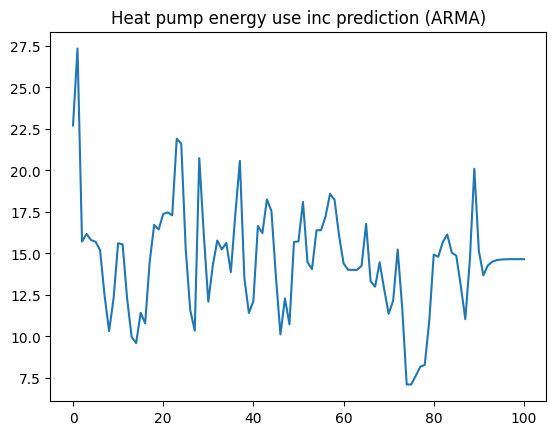

In [167]:
data_inc_forecasts = pd.concat([df_sum_sel['E_warmtepomp'], fitted_model.forecast(num_values_to_forecast)])
data_inc_forecasts.plot()
plt.title('Heat pump energy use inc prediction (ARMA)')
plt.show()

The forecasts are quite bad - a nearly straight line. 

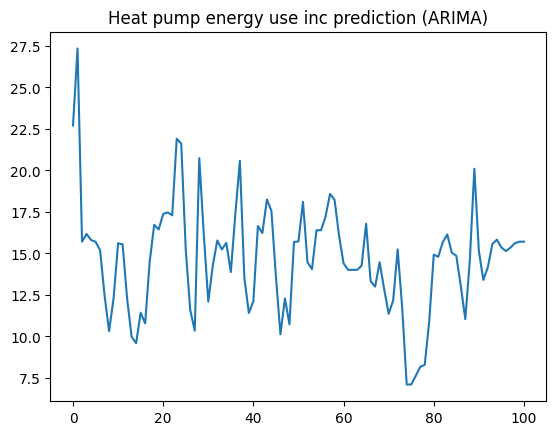

In [ ]:
# Play around with these parameters until you get a reasonable looking result.
num_previous_terms = 4 # Commonly called p
differencing_order = 3 # Now set it to 1 - or even higher to get rid of higher order trends and seasonality
num_terms_moving_average = 2 # Commonly called q

model_arima = tsa.ARIMA(df_sum_sel['E_warmtepomp'], order=(num_previous_terms, differencing_order, num_terms_moving_average), enforce_invertibility=False)

fitted_model_arima = model_arima.fit()

data_inc_forecasts = pd.concat([df_sum_sel['E_warmtepomp'], fitted_model_arima.forecast(num_values_to_forecast)])
data_inc_forecasts.plot()
plt.title('Heat pump energy use inc prediction (ARIMA)')
plt.show()


Still not very good. Our data is simply too noisy to work well. How bad is it? To find this out, we need to split the data into a train set and a test set. FOR THIS WE DO NOT USE scikit-learn's train_test_split!

Then we make predictions on the train set and compare those to the test set using mean_absolute_error and mean_absolute_percentage_error from sklearn.metrics.


In [273]:
# Create a train set and a test set. Last 10 readings are the test set.
train = df_sum_sel['E_warmtepomp'][:-10]
test = df_sum_sel['E_warmtepomp'][-10:]

# Play around with these parameters until you get a reasonable result.
num_previous_terms = 1 # Commonly called p
differencing_order = 2 # Now set it to 1 - or even higher to get rid of higher order trends and seasonality
num_terms_moving_average = 1 # Commonly called q

# Train a model
model_arima = tsa.ARIMA(train, order=(num_previous_terms, differencing_order, num_terms_moving_average), enforce_invertibility=False)

fitted_model_arima = model_arima.fit()

forecasts = fitted_model_arima.forecast(test.size)

# Calculate the MAPE
print(f'The MAPE is {mean_absolute_percentage_error(test, forecasts) * 100:.0f}%')


The MAPE is 11%


Now try it yourself on the complete data set. Create a train set and a test set (manually!)

For the parameters: play around with the number of previous terms and previous error terms to use. Note that larger values will lead to longer run times.

Also, try different test set sizes. What does this tell you about the predictive power of this model?

In [ ]:
# Your code goes here

The MAPE is 683%





TODO try earthquake time series for beter results